PlayWright Browser toolkits let your agent navigate the web and interact with dynamically rendered sites.

In [1]:
from langsmith import Client
import os

In [2]:
LANGSMITH_API_KEY =os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT =os.getenv('LANGSMITH_PROJECT')
LANGCHAIN_TRACING_V2=os.getenv('LANGCHAIN_TRACING_V2','true')

In [ ]:
#print(LANGSMITH_API_KEY,'\t',LANGSMITH_PROJECT,LANGCHAIN_TRACING_V2)

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 	 pr-large-safeguard-49 true


In [6]:
client =Client(api_key=LANGSMITH_API_KEY)

In [7]:
# This import is required only for notebooks, since they have their own eventloop for async process 
import nest_asyncio

nest_asyncio.apply()

In [8]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit #refer PlayWrightBrowserToolkit langchain docs
from langchain_community.tools.playwright.utils import (
    create_async_playwright_browser,  # A synchronous browser is available, though it isn't compatible with jupyter.\n",	  },
)

Instantiating a Browser Toolkit

In [9]:
#Create the browser
from langchain.agents import tool


async_browser = create_async_playwright_browser(headless=False) #If you set headless=True, it would run silently in the background (no window).
#wraps the Playwright browser inside a LangChain “toolkit
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools() # this is standard we have to use .get_tools()

checking tools Manually whether working properly or not

In [4]:
tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.710

In [5]:
for tool in tools:
    print(f'{tool.name}:\t {tool.description}: \t {tool}') #tool.name tool.description are common for for all LangChain toolkits

click_element:	 Click on an element with the given CSS selector: 	 async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
navigate_browser:	 Navigate a browser to the specified URL: 	 async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
previous_webpage:	 Navigate back to the previous page in the browser history: 	 async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.25>
extract_text:	 Extract all the text on the current webpage: 	 async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\Mohamed Arshad\AppData\Local\ms-playwright\chromium-1169\chrome-win\chrome.exe> version=136.0.7103.2

In [6]:
tool_dict ={}

for tool in tools:
    tool_dict[tool.name] =tool

#tool_dict

In [7]:
# for testing purposes running tools manually 
navigate_browser_tool =tool_dict.get('navigate_browser')
extract_text_tool = tool_dict.get('extract_text')

await navigate_browser_tool.arun({"url":"https://www.cnn.com"}) #arun -> asynchronous run
text = await extract_text_tool.arun({})


In [8]:
import textwrap #wraps long lines of text so they fit neatly in the console or output, instead of running endlessly on one line.

print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Sign 

Navigate to link which we given is cnn and extracting text from that webpage is working properly which is done manually

Next is define push notification tool,Define graph ,llm

In [10]:
import os
from dotenv import load_dotenv
from langchain.agents import Tool
import requests
from typing_extensions import TypedDict,Annotated
from langgraph.graph import START,StateGraph,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image,display
import gradio as gr


In [11]:
load_dotenv(override=True)

True

In [12]:
memory =MemorySaver()

In [13]:
pushover_url = "https://api.pushover.net/1/messages.json"
pushover_user = os.getenv('PUSHOVER_USER')
pushover_api = os.getenv('PUSHOVER_API')

In [29]:
from langsmith import traceable

@traceable(run_type="tool", name="Push_Notification_Tool")
def push(text):
    requests.post(url=pushover_url,data={"token":pushover_api,"user":pushover_user,"message":text})

tool_push =Tool(
    name='push_notification',
    func=push,
    description="sends push notifications when triggered"
)

In [15]:
#tool_push.invoke('hi')

Define State schema

In [16]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [17]:
print(type(tools))
print(type(tool_push))

<class 'list'>
<class 'langchain_core.tools.simple.Tool'>


In [18]:
# all_tools =tools+tool_push

In [19]:
#combine all tools

In [20]:
all_tools =tools+[tool_push]

In [21]:
llm =ChatOpenAI(model = 'gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools=all_tools)

def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}
    

Create graph object

In [22]:
graph_builder =StateGraph(State)

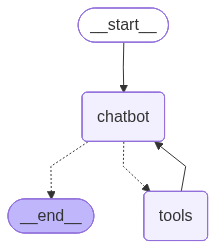

In [23]:
graph_builder.add_node('chatbot',chatbot)
graph_builder.add_node('tools',ToolNode(all_tools))
graph_builder.add_conditional_edges('chatbot',tools_condition, 'tools') #ools_condition is: a function that decides whether to go to the tools node or not, based on what the chatbot just produced like search a website =True etc.
graph_builder.add_edge(START,'chatbot')
graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge('chatbot',END)

memory =MemorySaver()
graph=graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))






In [ ]:
config ={"configurable":{"thread_id":"15"}}

from langsmith import traceable

@traceable(run_type="chain", name="Playwright_LangGraph_Chat")
async def chat(user_input,history):
    output = await graph.ainvoke({"messages":[{"role":"user","content":user_input}]},config=config)
    print(output)
    return output['messages'][-1].content

gr.ChatInterface(chat,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hello what is time now', additional_kwargs={}, response_metadata={}, id='9563d91b-84b3-488c-a859-8229bc46602b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5JLOTW8PiLoJ2zpryUgB14WO', 'function': {'arguments': '{}', 'name': 'extract_text'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 272, 'total_tokens': 282, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CXjufxwhxnIMgXrqgCgp84pH6oWkf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--23761c25-408e-4670-bb10-8c0bf58e4388-0', tool_calls=[{'name': 'extract_text', 'args': {}, 'id': 'call_5JLOTW8PiLoJ2zpryUgB14WO', 'type':

In [31]:
list(graph.get_state(config))

[{'messages': [HumanMessage(content='hello what is time now', additional_kwargs={}, response_metadata={}, id='9563d91b-84b3-488c-a859-8229bc46602b'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5JLOTW8PiLoJ2zpryUgB14WO', 'function': {'arguments': '{}', 'name': 'extract_text'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 272, 'total_tokens': 282, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CXjufxwhxnIMgXrqgCgp84pH6oWkf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--23761c25-408e-4670-bb10-8c0bf58e4388-0', tool_calls=[{'name': 'extract_text', 'args': {}, 'id': 'call_5JLOTW8PiLoJ2zpryUgB14WO', 'ty